# Problem Statement ❔

The following is a database of 1698 Hindi Movies from 2005-2017: [https://www.kaggle.com/datasets/rishidamarla/bollywood-movies-dataset](https://www.kaggle.com/datasets/rishidamarla/bollywood-movies-dataset)

[Local Data](/data/bollywood-movie-dataset.csv)

A movie is a `hit` if _revenue_ > _budget_, and it is a `flop` otherwise. The goal is to predict whether a movie will be a `hit` or `flop`, given all the other attributes.

Once again, your task is to build two classifiers for this data set: a Decision Tree and a Naïve Bayes classifier. Use a suitable evaluation metric to compare the performance of the the classifiers.

# Solution ✅

## Decision Tree Classifier 🌲

#### 1.1 Packages Import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz as gviz
import missingno as msno

from sklearn.preprocessing import OrdinalEncoder

from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, make_scorer

from datetime import datetime
import calendar

from time import perf_counter_ns as perf
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
model_count = 0

#### 1.2 Extract CSV data into pandas DataFrame

In [3]:
df_original = pd.read_csv("./datasets/bollywood-movie-dataset.csv")

### 2. Data Description

#### 2.1 Top 5 records

In [4]:
df_original.head()

,Movie Name,Release Period,Whether Remake,Whether Franchise,Genre,New Actor,New Director,New Music Director,Lead Star,Director,Music Director,Number of Screens,Revenue(INR),Budget(INR)
0,Golden Boys,Normal,No,No,suspense,Yes,No,No,Jeet Goswami,Ravi Varma,Baba Jagirdar,5,5000000,85000
1,Kaccha Limboo,Holiday,No,No,drama,Yes,No,Yes,Karan Bhanushali,Sagar Ballary,Amardeep Nijjer,75,15000000,825000
2,Not A Love Story,Holiday,No,No,thriller,No,No,No,Mahie Gill,Ram Gopal Verma,Sandeep Chowta,525,75000000,56700000
3,Qaidi Band,Holiday,No,No,drama,Yes,No,No,Aadar Jain,Habib Faisal,Amit Trivedi,800,210000000,4500000
4,Chaatwali,Holiday,No,No,adult,Yes,Yes,Yes,Aadil Khan,Aadil Khan,Babloo Ustad,1,1000000,1075000


In [8]:
df_original['Number of Screens'].min(),df_original['Number of Screens'].max()

(1, 4600)

In [7]:
df_original['Revenue(INR)'].min(),df_original['Revenue(INR)'].max()

(325000, 2100000000)

In [5]:
df_original.columns

Index(['Movie Name', 'Release Period', 'Whether Remake', 'Whether Franchise',
       'Genre', 'New Actor', 'New Director', 'New Music Director', 'Lead Star',
       'Director', 'Music Director', 'Number of Screens', 'Revenue(INR)',
       'Budget(INR)'],
      dtype='object')

#### 2.2 Shape of the dataset

In [6]:
print(f'Count of (Records, Features) = {df_original.shape}')

Count of (Records, Features) = (1698, 14)


#### 2.3 Datatype of features

In [7]:
feature_description = df_original.dtypes
print(feature_description)

Movie Name            object
Release Period        object
Whether Remake        object
Whether Franchise     object
Genre                 object
New Actor             object
New Director          object
New Music Director    object
Lead Star             object
Director              object
Music Director        object
Number of Screens      int64
Revenue(INR)           int64
Budget(INR)            int64
dtype: object


##### Seperate features based on the datatype

In [8]:
categorical_features = feature_description[feature_description=='O'].index
discrete_numerical_features = feature_description[feature_description=='int64'].index
continuous_numerical_features = feature_description[feature_description=='float'].index

print(f'There are {len(categorical_features)} Categorical, {len(discrete_numerical_features)} Discrete Numerical and {len(continuous_numerical_features)} Continuous Numerical features in the dataset.')

There are 11 Categorical, 3 Discrete Numerical and 0 Continuous Numerical features in the dataset.


By analysing real world box-office data we can corroborate that, the `Revenue(INR)` and `Budget(INR)` of the dataframe need to be interchanged.

In [9]:
df_original[df_original.columns[[-1,-2]]] = df_original[df_original.columns[[-2, -1]]]
df_original.head()

,Movie Name,Release Period,Whether Remake,Whether Franchise,Genre,New Actor,New Director,New Music Director,Lead Star,Director,Music Director,Number of Screens,Revenue(INR),Budget(INR)
0,Golden Boys,Normal,No,No,suspense,Yes,No,No,Jeet Goswami,Ravi Varma,Baba Jagirdar,5,85000,5000000
1,Kaccha Limboo,Holiday,No,No,drama,Yes,No,Yes,Karan Bhanushali,Sagar Ballary,Amardeep Nijjer,75,825000,15000000
2,Not A Love Story,Holiday,No,No,thriller,No,No,No,Mahie Gill,Ram Gopal Verma,Sandeep Chowta,525,56700000,75000000
3,Qaidi Band,Holiday,No,No,drama,Yes,No,No,Aadar Jain,Habib Faisal,Amit Trivedi,800,4500000,210000000
4,Chaatwali,Holiday,No,No,adult,Yes,Yes,Yes,Aadil Khan,Aadil Khan,Babloo Ustad,1,1075000,1000000


#### 2.4 Making of Target variable

In [10]:
df_original['hit'] = (df_original['Revenue(INR)'] > df_original['Budget(INR)']).apply(lambda x: int(x))
df_original.loc[0]

Movie Name              Golden Boys
Release Period               Normal
Whether Remake                   No
Whether Franchise                No
Genre                      suspense
New Actor                       Yes
New Director                     No
New Music Director               No
Lead Star              Jeet Goswami
Director                 Ravi Varma
Music Director        Baba Jagirdar
Number of Screens                 5
Revenue(INR)                  85000
Budget(INR)                 5000000
hit                               0
Name: 0, dtype: object

### 3. Data Checks to perform

- Check Duplicates
- Check data types and unique values of each column
- Check unique items in each Categorical feature
- Check missing values
- Check statistics of numerical variables of the dataset
- Check collinearity among the Numerical variables

#### 3.1 Check Duplicates

In [11]:
df_original.duplicated().sum()

2

#### 3.2 Check data types and unique values of each column

In [12]:
feature_description = pd.DataFrame(pd.concat([df_original.dtypes, df_original.nunique()], axis=1).rename(columns={0:'datatype', 1:'unique_value_count'}))

print(feature_description)

                   datatype  unique_value_count
Movie Name           object                1695
Release Period       object                   2
Whether Remake       object                   2
Whether Franchise    object                   2
Genre                object                  14
New Actor            object                   2
New Director         object                   2
New Music Director   object                   2
Lead Star            object                 764
Director             object                1048
Music Director       object                 630
Number of Screens     int64                 147
Revenue(INR)          int64                1104
Budget(INR)           int64                 184
hit                   int64                   2


#### 3.3 Check unique categories in each Categorical feature

In [13]:
for feature in categorical_features:
    print(f'Categories in {feature.upper()} variable:\n{df_original[feature].unique()}\n')

Categories in MOVIE NAME variable:
['Golden Boys' 'Kaccha Limboo' 'Not A Love Story' ...
 'Dunno Y Na Jaane Kyun' 'Taj Mahal - An Eternal Love Story'
 'Mr. Hot Mr. Kool']

Categories in RELEASE PERIOD variable:
['Normal' 'Holiday']

Categories in WHETHER REMAKE variable:
['No' 'Yes']

Categories in WHETHER FRANCHISE variable:
['No' 'Yes']

Categories in GENRE variable:
['suspense' 'drama' 'thriller' 'adult' 'comedy' 'action' 'love_story'
 'rom__com' 'horror' 'fantasy' 'masala' 'mythological' 'animation'
 'documentary']

Categories in NEW ACTOR variable:
['Yes' 'No']

Categories in NEW DIRECTOR variable:
['No' 'Yes']

Categories in NEW MUSIC DIRECTOR variable:
['No' 'Yes']

Categories in LEAD STAR variable:
['Jeet Goswami' 'Karan Bhanushali' 'Mahie Gill' 'Aadar Jain' 'Aadil Khan'
 'Aakar Kaushik' 'Aakash' 'Aamir Bashir' 'Aamir Khan' 'Aanamika Bawa'
 'Aarun Nagar' 'Aaryan' 'Aasad Mirza' 'Aashish Chanana'
 'Aashish Chaudhary' 'Aasif Albela' 'Aatri Kumar' 'Abhay Bakshi'
 'Abhay Deol' 'Abhi

#### 3.4 Check Missing values

In [14]:
df_original.isna().sum()

Movie Name            0
Release Period        0
Whether Remake        0
Whether Franchise     0
Genre                 0
New Actor             0
New Director          0
New Music Director    0
Lead Star             0
Director              0
Music Director        0
Number of Screens     0
Revenue(INR)          0
Budget(INR)           0
hit                   0
dtype: int64

Manually checking and by using inbuilt package both seems to conclude that the dataset has no missing values.

#### 3.5. Check statistics of numerical variables of the dataset

In [15]:
df_original.drop(columns=['hit']).describe()

,Number of Screens,Revenue(INR),Budget(INR)
count,1698.000000,1.698000e+03,1.698000e+03
mean,553.831567,2.377287e+08,1.501674e+08
std,782.951839,6.134398e+08,2.434838e+08
min,1.000000,7.250000e+03,3.250000e+05
25%,30.000000,1.150000e+06,1.500000e+07
50%,200.000000,1.240000e+07,5.500000e+07
75%,800.000000,1.778325e+08,1.900000e+08
max,4600.000000,8.016120e+09,2.100000e+09


#### 3.6. Check collinearity among the Numerical variables

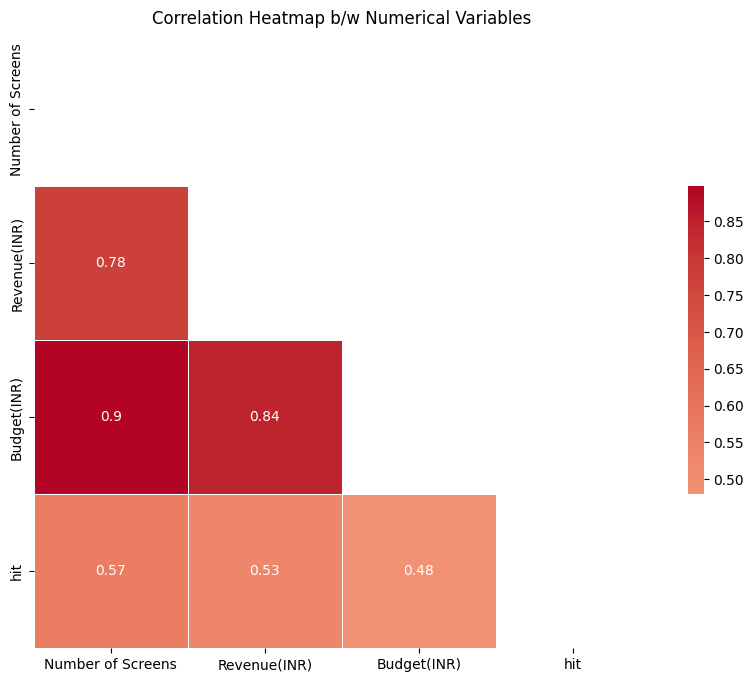

In [16]:
# Compute the correlation matrix
corr = df_original.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))

# Generate the heatmap with Seaborn
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Set the title of the plot
plt.title('Correlation Heatmap b/w Numerical Variables')

# Show the plot
plt.show()

### 4 Data Cleaning

#### 4.1 Drop Columns


Splitting the dataset into explanatory and target variable.

In [17]:
X, y = df_original.drop(columns=['Revenue(INR)','hit']), df_original['hit']
X.head()

,Movie Name,Release Period,Whether Remake,Whether Franchise,Genre,New Actor,New Director,New Music Director,Lead Star,Director,Music Director,Number of Screens,Budget(INR)
0,Golden Boys,Normal,No,No,suspense,Yes,No,No,Jeet Goswami,Ravi Varma,Baba Jagirdar,5,5000000
1,Kaccha Limboo,Holiday,No,No,drama,Yes,No,Yes,Karan Bhanushali,Sagar Ballary,Amardeep Nijjer,75,15000000
2,Not A Love Story,Holiday,No,No,thriller,No,No,No,Mahie Gill,Ram Gopal Verma,Sandeep Chowta,525,75000000
3,Qaidi Band,Holiday,No,No,drama,Yes,No,No,Aadar Jain,Habib Faisal,Amit Trivedi,800,210000000
4,Chaatwali,Holiday,No,No,adult,Yes,Yes,Yes,Aadil Khan,Aadil Khan,Babloo Ustad,1,1000000


From **3.2** and **3.3** we can see `Movie Name` has nearly equal no. of categories as the no. of records. Therefore keeping this feature would lead to high variance.

Similarly, other categorical features like `Lead Star`, `Director` & `Music Director` has unique categories $>33\%$ of total records count. As Decision Tree Classifier model is **prone to overfitting**, therefore dropping these features would reduce the complexity of the model and thus stop it from overfitting.

In [18]:
X = X.drop(columns=['Movie Name','Lead Star',
       'Director', 'Music Director'])

In [19]:
X.columns

Index(['Release Period', 'Whether Remake', 'Whether Franchise', 'Genre',
       'New Actor', 'New Director', 'New Music Director', 'Number of Screens',
       'Budget(INR)'],
      dtype='object')

In [20]:
X.head()

,Release Period,Whether Remake,Whether Franchise,Genre,New Actor,New Director,New Music Director,Number of Screens,Budget(INR)
0,Normal,No,No,suspense,Yes,No,No,5,5000000
1,Holiday,No,No,drama,Yes,No,Yes,75,15000000
2,Holiday,No,No,thriller,No,No,No,525,75000000
3,Holiday,No,No,drama,Yes,No,No,800,210000000
4,Holiday,No,No,adult,Yes,Yes,Yes,1,1000000


### 5 Data Transform

#### 5.1 Encoding
No feature which seems to have Ordinal properties.

##### Dummies Encoding

In [21]:
X = pd.get_dummies(X, drop_first=True)

In [22]:
X.head()

,Number of Screens,Budget(INR),Release Period_Normal,Whether Remake_Yes,Whether Franchise_Yes,Genre_adult,Genre_animation,Genre_comedy,Genre_documentary,Genre_drama,...,Genre_horror,Genre_love_story,Genre_masala,Genre_mythological,Genre_rom__com,Genre_suspense,Genre_thriller,New Actor_Yes,New Director_Yes,New Music Director_Yes
0,5,5000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,75,15000000,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
2,525,75000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,800,210000000,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,1,1000000,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1


In [23]:
X.columns

Index(['Number of Screens', 'Budget(INR)', 'Release Period_Normal',
       'Whether Remake_Yes', 'Whether Franchise_Yes', 'Genre_adult',
       'Genre_animation', 'Genre_comedy', 'Genre_documentary', 'Genre_drama',
       'Genre_fantasy', 'Genre_horror', 'Genre_love_story', 'Genre_masala',
       'Genre_mythological', 'Genre_rom__com', 'Genre_suspense',
       'Genre_thriller', 'New Actor_Yes', 'New Director_Yes',
       'New Music Director_Yes'],
      dtype='object')

### 6 Fitting Model

#### 6.1 Dividing Dataset into Train and Test sets

As dataset is highly imbalanced, Train-Test split must be **stratified**.

In [24]:
# split train 80% & test 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state=51, stratify=y)

In [25]:
print('train\n',y_train.value_counts(normalize=True),'\n\ntest\n',y_test.value_counts(normalize=True))

train
 0    0.723859
1    0.276141
Name: hit, dtype: float64 

test
 0    0.723529
1    0.276471
Name: hit, dtype: float64


#### 6.2 Model buildinig

##### Choosing Performance Metrics

**Not buying a movie which my model predicted to be a flop but ended up being a once-in-a-decade hit movie could be more detrimental from a business POV.**

The reason is that business like the OTT platform has to pay a considerable amount of money to acquire the digital rights of a movie, and not buying a potentially successful movie may result in losing out on revenue and market share to competitors. In contrast, if the company buys a movie that ends up being a flop, the financial loss can be absorbed by the company as part of its risk management strategy.

In [26]:
# weighted recall is chosen as performance metrics
weighted_recall = make_scorer(recall_score, average='weighted')

##### UDF for measuring time to train the best estimator model and its size

In [27]:
def model_measure(estimator, X_train, y_train):
    global model_count
    start_time = perf()
    trained_model = estimator.fit(X_train, y_train)
    model_time_to_train = perf() - start_time

    dir_path = './model_files/Q2/'

    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    with open(f'{dir_path}{str(model_count)}.pkl','wb') as file:
        pickle.dump(trained_model, file)

    # measure the model size
    PATH = f'{dir_path}{str(model_count)}.pkl'
    model_size = os.path.getsize(PATH)/1024

    model_count += 1
    return trained_model, model_time_to_train, model_size


In [28]:
def eval_metrics(test, pred):
    return recall_score(test, pred, average='weighted'), accuracy_score(test, pred), precision_score(test, pred), roc_auc_score(test, pred), confusion_matrix(test, pred)

##### Hyperparameter Tuning and Cross Validation
Iteratively train model on the variable CV folds

In [29]:
# define the hyperparameter grid to search over
param_grid = {
    'criterion':['gini','entropy'],
    'max_depth': [*range(2,6)],
    'min_samples_split': [1, 2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4, 5, 10, 12]
}

CVfold_train_score = {}
for fold in range(2,9):
    # create a decision tree classifier instance
    DTclf = DecisionTreeClassifier()

    # create a GridSearchCV instance with the decision tree classifier and hyperparameter grid
    grid_search = GridSearchCV(DTclf, param_grid=param_grid, scoring=weighted_recall, cv=fold)

    # fit the GridSearchCV instance on the data
    grid_search.fit(X_train, y_train)
    best_clf = grid_search.best_estimator_
    dt_train_score = grid_search.best_score_

    CVfold_train_score[fold] = dt_train_score

##### Ideal count of CV folds
- depending on train score

In [30]:
ideal_fold = sorted(CVfold_train_score.items(), key=lambda x:x[1], reverse=True)[0][0]
ideal_fold

5

##### Train model on ideal count of CV folds and predict

In [31]:
DTclf = DecisionTreeClassifier()

# create a GridSearchCV instance with the decision tree classifier and hyperparameter grid and ideal count of CV folds
grid_search = GridSearchCV(DTclf, param_grid=param_grid, scoring=weighted_recall, cv=ideal_fold)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 10, 12],
                         'min_samples_split': [1, 2, 3, 4, 5]},
             scoring=make_scorer(recall_score, average=weighted))

##### Test Model

In [32]:
vanila_model = DecisionTreeClassifier(**grid_search.best_params_)

# measure time to train the best estimator model and its size
best_clf, dt_time_to_train, dt_model_size = model_measure(vanila_model, X_train, y_train)

dt_train_score = grid_search.best_score_
y_pred = best_clf.predict(X_test)

dt_test_score, dt_test_acc, dt_test_prec, dt_test_roc, conf_mat = eval_metrics(y_test, y_pred)
print('Best Train Score:',round(dt_train_score,6),',Test Score:', round(dt_test_score,6))

Best Train Score: 0.818125 ,Test Score: 0.805882


##### Confusion Matrix

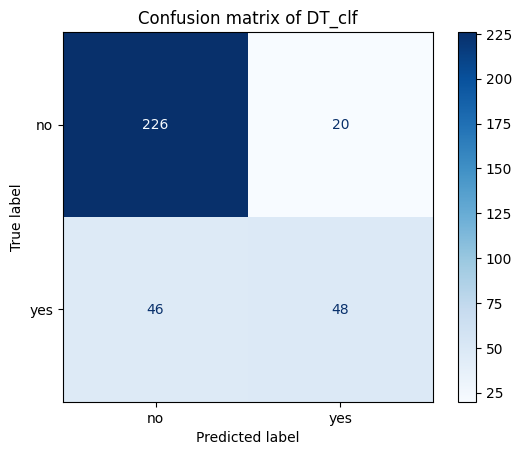

In [33]:
# create the confusion matrix display
cmd = ConfusionMatrixDisplay(conf_mat, display_labels=['no', 'yes'])

# plot the confusion matrix
cmd.plot(cmap=plt.cm.Blues)

# add a title and axis labels
plt.title('Confusion matrix of DT_clf')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# show the plot
plt.show()

##### Storing model train & test metrics

In [34]:
model_scores = pd.DataFrame(columns=['train_whtd_rcl', 'test_whtd_rcl', 'test_acc', 'test_prec', 'test_roc','time_to_train(ns)','model_size(KB)'])
model_scores.loc['DTclf'] = [dt_train_score, dt_test_score, dt_test_acc, dt_test_prec, dt_test_roc, dt_time_to_train, dt_model_size]
model_scores

,train_whtd_rcl,test_whtd_rcl,test_acc,test_prec,test_roc,time_to_train(ns),model_size(KB)
DTclf,0.818125,0.805882,0.805882,0.705882,0.714669,5325000.0,3.639648


BEST PARAMETER

In [35]:
print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 1}


#### 6.3 Tree Graphics

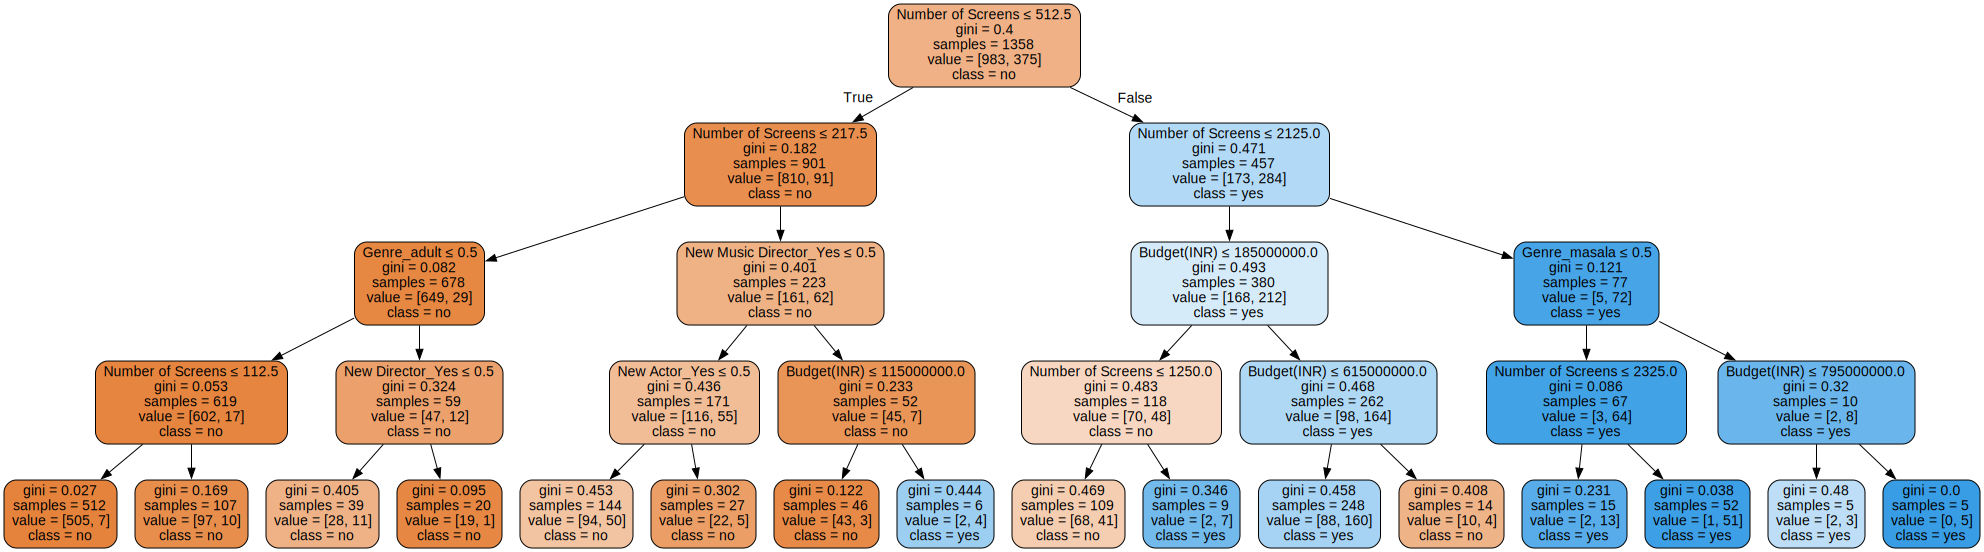

In [36]:
import graphviz
dot_data = export_graphviz(best_clf, out_file=None, feature_names=X.columns,
                           class_names=['no','yes'], filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph

## NB Classifier 🤓

### Have to follow steps from 1 to 5 of Decision Tree Classifier. After that...

In [37]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import cross_val_score

### 6 Fitting Model

In [38]:
X_nb = X.copy()
X_nb.describe().loc['min'].min()

0.0

Dataset has no negetive value. No need to Normalize.

In [39]:
X_nb.head()

,Number of Screens,Budget(INR),Release Period_Normal,Whether Remake_Yes,Whether Franchise_Yes,Genre_adult,Genre_animation,Genre_comedy,Genre_documentary,Genre_drama,...,Genre_horror,Genre_love_story,Genre_masala,Genre_mythological,Genre_rom__com,Genre_suspense,Genre_thriller,New Actor_Yes,New Director_Yes,New Music Director_Yes
0,5,5000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,75,15000000,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
2,525,75000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,800,210000000,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,1,1000000,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1


#### 6.1 Dividing Dataset into Train and Test sets

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_nb, y, test_size=0.2,stratify=y, random_state=42)

In [41]:
print('train\n',y_train.value_counts(normalize=True),'\n\ntest\n',y_test.value_counts(normalize=True))

train
 0    0.723859
1    0.276141
Name: hit, dtype: float64 

test
 0    0.723529
1    0.276471
Name: hit, dtype: float64


#### 6.2 Model building

##### NB Classifier Models

In [42]:
nb_models = {'gnb':GaussianNB(),
            'mnb':MultinomialNB(),
            'bnb':BernoulliNB()}

##### Performance metric ~ Weighted Recall

In [43]:
weighted_recall = make_scorer(recall_score, average='weighted')

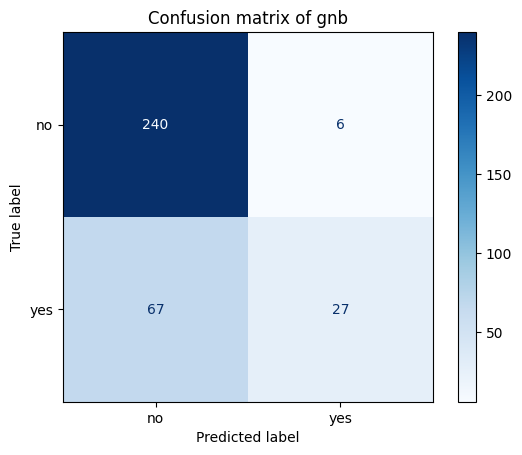

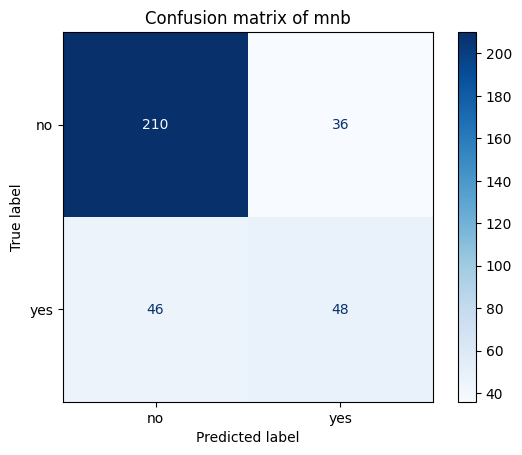

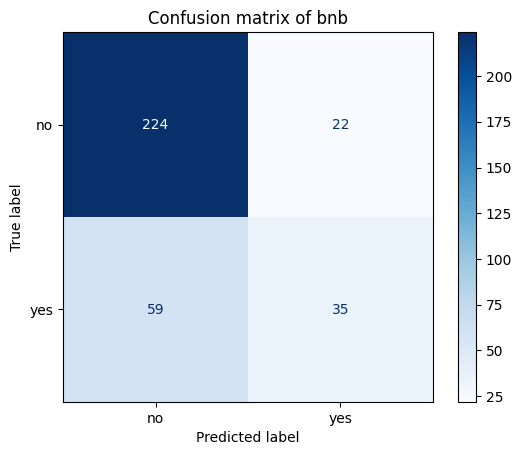

In [44]:
for model in nb_models:
    # average of all performance metrics calculated from each fold
    nb_mean_train_score = cross_val_score(estimator=nb_models[model],X=X_train,y=y_train,cv=5, scoring=weighted_recall).mean()

    fit_model, time_to_train, model_size = model_measure(nb_models[model],X_train, y_train)

    # calculate predicted values
    y_pred = fit_model.predict(X_test)
    
    nb_test_score, nb_test_acc, nb_test_prec, nb_test_roc, conf_mat = eval_metrics(y_test, y_pred)

    model_scores.loc[model] = [nb_mean_train_score, nb_test_score, nb_test_acc, nb_test_prec, nb_test_roc, time_to_train, model_size]

    # create the confusion matrix display
    cmd = ConfusionMatrixDisplay(conf_mat, display_labels=['no', 'yes'])

    # plot the confusion matrix
    cmd.plot(cmap=plt.cm.Blues)

    # add a title and axis labels
    plt.title(f'Confusion matrix of {model}')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    # show the plot
    plt.show()

##### Compare Performance b/w DTClassifier & NBClassifier models

In [45]:
model_scores

,train_whtd_rcl,test_whtd_rcl,test_acc,test_prec,test_roc,time_to_train(ns),model_size(KB)
DTclf,0.818125,0.805882,0.805882,0.705882,0.714669,5325000.0,3.639648
gnb,0.784241,0.785294,0.785294,0.818182,0.631422,3338600.0,1.682617
mnb,0.749677,0.758824,0.758824,0.571429,0.682148,2518300.0,1.700195
bnb,0.722374,0.761765,0.761765,0.614035,0.641455,1960200.0,1.717773
